# Regressão Softmax com dados do MNIST

O objetivo deste notebook é ilustrar o uso do mesmo código matricial desenvolvido para a classificação das Flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.


## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

## Funções já discutidas em notebooks anteriores

In [2]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

def getAccuracy(model, inputs, targets):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = (predicts == targets).mean()
    return accuracy

## Carregamento dos dados do MNIST

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
train_dataset = MNIST(dataset_dir, train=True,  transform=data_transform)
test_dataset  = MNIST(dataset_dir, train=False, transform=data_transform)

print("Tamanho do dataset de treino:", len(train_dataset))
print("Tamanho do dataset de teste: ", len(test_dataset))

print("\nDimensões dos dados das imagens:", train_dataset[0][0].size())
print("Tipo dos dados das imagens:     ", type(train_dataset[0][0]))
print("Tipo das classes das imagens:   ", type(train_dataset[0][1]))

Tamanho do dataset de treino: 60000
Tamanho do dataset de teste:  10000

Dimensões dos dados das imagens: torch.Size([1, 28, 28])
Tipo dos dados das imagens:      <class 'torch.FloatTensor'>
Tipo das classes das imagens:    <class 'int'>


## Organizando e normalizando os dados

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras para testes.


In [4]:
n_samples_train = 500
n_samples_test  = 100

train_dataset.train_data   = train_dataset.train_data[:n_samples_train]
train_dataset.train_labels = train_dataset.train_labels[:n_samples_train]
test_dataset.test_data   = test_dataset.test_data[:n_samples_test]
test_dataset.test_labels = test_dataset.test_labels[:n_samples_test]

print('Amostras para treinamento:', len(train_dataset))
print('Amostras para validação:',   len(test_dataset))

Amostras para treinamento: 500
Amostras para validação: 100


## Visualizando os dados

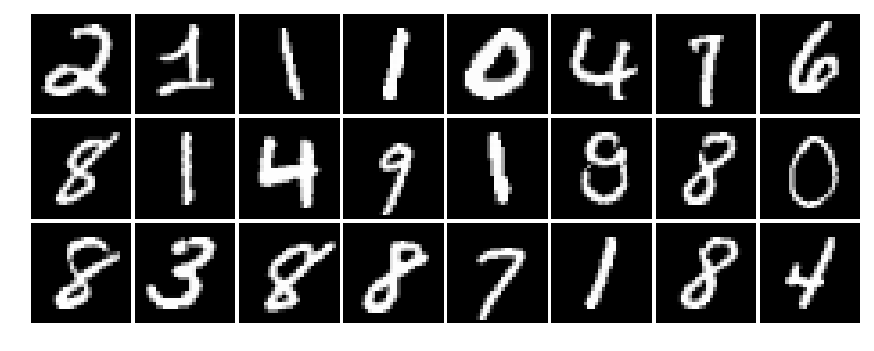

In [5]:
n_samples = 24

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=n_samples,
                                              shuffle=True)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Visualizando uma imagem com o matplotlib

class: 5


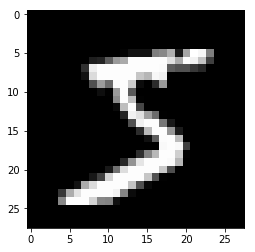

In [6]:
image, target = train_dataset[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Treinamento

### Inicialização dos parâmetros

In [32]:
epochs = 100
learningRate = 0.5

# Cria um DataLoader de somente um batch
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=16,
                                               shuffle=True)

# Pega todas as imagens de uma vez


# Cria uma operação linear com entrada de tamanho 28*28 e saída com 10 neurônios (classes)
# O objeto criado armazenará os pesos
model = torch.nn.Linear(28*28, 10)

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss(size_average=True)
criterion2 = torch.nn.CrossEntropyLoss(size_average=False)

# Nosso otomizador será SDG
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos pesos

In [40]:
losses = []

for i in range(epochs):
    loss_sum = 0
    loss2_sum= 0
    
    for batch in train_dataloader:
        # separa os dados do batch
        input_data, targets_data = batch
        # Transforma a entrada para uma dimensão
        input_data = input_data.view(-1, 28*28)
    
        # calcula a saída da operação linear
        output = model(Variable(input_data))

        # calcula a perda
        loss = criterion(output, Variable(targets_data))
        loss_sum += loss.data[0] * targets_data.size(0)
        loss2 = criterion2(output, Variable(targets_data))
        loss2_sum += loss2
        
        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = loss_sum / len(train_dataset)
    epoch2_loss = loss2_sum/ len(train_dataset)
    losses.append(epoch_loss)
    

In [41]:
print('Final loss:', epoch_loss, epoch2_loss.data[0])

Final loss: 0.0015997751159593462 0.0015997751615941525


In [37]:
1/(0.1506661695893854/ 2.3205604553222656)

15.402000738762737

## Visualizando gráfico de perda durante o treinamento

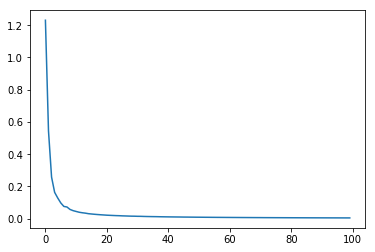

In [9]:
plt.plot(losses)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [10]:
def getAccuracy(model, inputs, targets):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = (predicts == targets).mean()
    return accuracy

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=len(train_dataset),
                                              shuffle=False)
train_input, targets_data = next(iter(train_dataloader))
train_input = train_input.view(-1, 28*28)

print('Training Accuracy: ', getAccuracy(model, train_input, targets_data))



test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=len(test_dataset),
                                              shuffle=False)
test_input, test_labels = next(iter(test_dataloader))
test_input = test_input.view(-1, 28*28)

print('Test Accuracy: ', getAccuracy(model, test_input, test_labels))

Training Accuracy:  1.0
Test Accuracy:  0.84


## Matriz de confusão com dados de treinamento e teste

In [11]:
print('Matriz de confusão (Treino):')
pd.crosstab(predict(model, train_input), targets_data.numpy())

Matriz de confusão (Treino):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0
1,0,66,0,0,0,0,0,0,0,0
2,0,0,52,0,0,0,0,0,0,0
3,0,0,0,50,0,0,0,0,0,0
4,0,0,0,0,52,0,0,0,0,0
5,0,0,0,0,0,39,0,0,0,0
6,0,0,0,0,0,0,45,0,0,0
7,0,0,0,0,0,0,0,52,0,0
8,0,0,0,0,0,0,0,0,39,0


In [12]:
print('Matriz de confusão (Teste):')
pd.crosstab(predict(model, test_input), test_labels.numpy())

Matriz de confusão (Teste):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,8,0,0,0,0,0,0,0,0,0
1,0,14,0,0,0,0,0,0,0,0
2,0,0,7,0,0,1,1,1,0,0
3,0,0,1,11,0,2,0,0,0,0
4,0,0,0,0,11,1,0,0,0,0
5,0,0,0,0,0,2,0,0,1,0
6,0,0,0,0,1,0,9,0,0,0
7,0,0,0,0,0,1,0,12,0,2
8,0,0,0,0,0,0,0,0,1,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


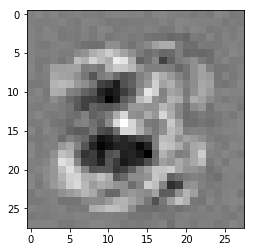

In [13]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

## Visualizando os pesos de todas as classes

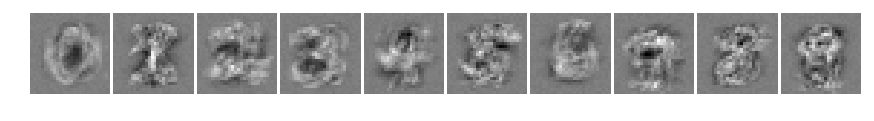

In [14]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Diagrama da regressão softmax com visualização dos pesos W

<img src="../figures/RegressaoSoftmaxArgmaxNMIST.png",width = 400>


# Atividades

## Exercícios

1. Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_oh_hat e o y_hat, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

class: 4


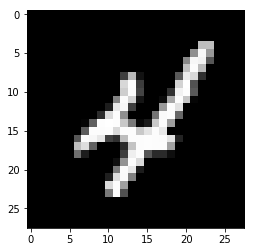

In [15]:
image, target = train_dataset[9]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

2. Insira código no laço do treinamento para que no final de cada época, 
seja impresso: o número da época e a perda e a acurácia
3. Insira código no laço de treinamento para que seja impresso a contagem
de mini-batches ocorrida em cada época.

## Perguntas

1. Qual é o tamanho do mini-batch?
2. Em uma época, quantos mini-batches existem?
3. Por que no treino, a acurácia é 100%, mas no teste foi de 84,5%
4. Por que no treino, a acurácia é 100%, porém a função de perda final não é zero, mas sim 0,015 ?
5. O que se deve fazer para que a avaliação no conjunto de teste seja melhorado?

## Conclusões sobre os experimentos deste notebook
